## Self-driving Car Project 5: Vehicle Detection and Tracking
The goals / steps of this project are the following:

* Training a classifier to detect vehicle images using color space feature, color histogram features, and HOG features.

* Implement a sliding-window technique and use the trained classifier to search for vehicles in images.

* Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

* Estimate a bounding box for vehicles detected.


In [2]:
# Import libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
%matplotlib inline
import time
import math

# Libaries for video 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Libaries for machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import blob_dog, blob_log, blob_doh
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

## 0. Load Data

### Load Image Directory
Prepare training set and test set use image from different folder to prevent leaking.
Training image
Vehicles: GTI_far, GTI_left, GTI_right, GTI_MiddleClose
Non-vehicles: Extra
Test image 
Vehicles:KITTI_extracted 
Non-vehicles: GTI 

In [3]:
# prepare cars training set
cars_train = []
notcars_train = []

# car
images = glob.glob('/Users/daruizhang/Documents/vehicles/KITTI_extracted/*.png') # cars
for image in images:
    cars_train.append(image)

# non-car
images = glob.glob('/Users/daruizhang/Documents/non-vehicles/Extras/*.png') # noncars
for image in images:
    notcars_train.append(image)

In [4]:
# prepare test set image from a different folder
cars_test = []
notcars_test = []

# car
images = glob.glob('/Users/daruizhang/Documents/vehicles/GTI_Far/*.png') # cars
for image in images:
    cars_test.append(image)

images = glob.glob('/Users/daruizhang/Documents/vehicles/GTI_Left/*.png') # cars
for image in images:
    cars_test.append(image)

images = glob.glob('/Users/daruizhang/Documents/vehicles/GTI_MiddleClose/*.png') # cars
for image in images:
    cars_test.append(image)

images = glob.glob('/Users/daruizhang/Documents/vehicles/GTI_Right/*.png') # cars
for image in images:
    cars_test.append(image)

# non-car
images = glob.glob('/Users/daruizhang/Documents/non-vehicles/GTI/*.png') # noncars
for image in images:
    notcars_test.append(image)

### Data Summary
Printed out some basic information of the data set such as number of image in each class

In [5]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

Car images:     5966
Non-car images: 5766
Image size:     (64, 64, 3)
Data type:      float32


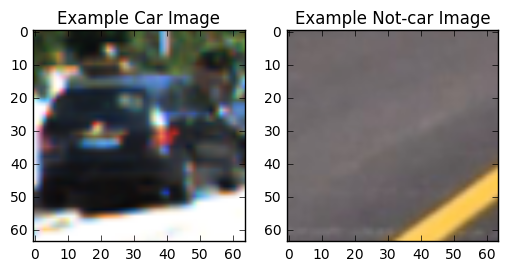

In [6]:
# Basic data summary
data_info = data_look(cars_train, notcars_train)
print('Car images:    ', data_info["n_cars"])
print('Non-car images:', data_info["n_notcars"])
print('Image size:    ', data_info["image_shape"])
print('Data type:     ', data_info["data_type"])


# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars_train))
notcar_ind = np.random.randint(0, len(notcars_train))
    
# Read in car / not-car images
car_image = mpimg.imread(cars_train[car_ind])
noncar_image = mpimg.imread(notcars_train[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(noncar_image)
plt.title('Example Not-car Image')

## 1. Define Features
Define features for the vehicle classification.Three types of features are used: color space feature, color histogram features, and HOG features.

### Convert Image Datatype
The images in the training data set are of the jpeg format, with float data values range from 0-1. The test images are of the png format, range from 0-255. To be consistent with the images type in the later process. I first convert the training image data type to int type with value from 0 to 255 

In [7]:
image_rgb = np.uint8(car_image*255)# convert to 255

### Spatial features
Color space feature uses the raw pixel values of the images and flattens them into a vector. To reduce the size of the image, I performed spatial binning on an image by resizing the image to the lower resolution.

In [8]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    spatial_features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return spatial_features 

Spatial features size: (64,)


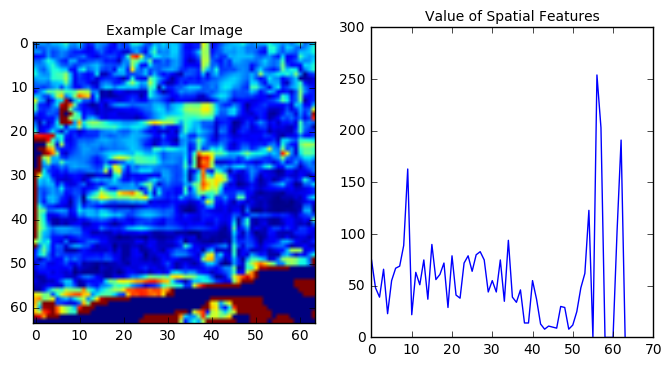

In [9]:
# set tuning parameters
spatial = 8 # size of the spacial bins

image_hls = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HLS) # convert it to HLS
# extract spatial features
# work on the saturation channel
spatial_s = bin_spatial(image_hls[:,:,2], size=(spatial, spatial))

print('Spatial features size:', spatial_s.shape)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.imshow(image_hls[:,:,2])
ax1.set_title('Example Car Image', fontsize=10)
ax2.plot(spatial_s)
ax2.set_title('Value of Spatial Features', fontsize=10)


### Color Histogram Features
Color Histogram feature is more robust to the different the appearance of the car.  The Color Histogram remove the structural relation and allow more flexibility to the variance of the image.
Binning is performed to the histogram of each channel. Both the RGB and HLS channels are used. 

In [10]:
def color_hist(img, nbins=32, bins_range=(0, 256),hist_vec=True):
    # Compute the histogram of the RGB channels separately
    hist1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = hist1[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hist1[0], hist2[0], hist3[0]))
    
    if hist_vec == False:
        # Return the individual histograms, bin_centers and feature vector    
        return hist1, hist2, hist3, bin_centers, hist_features
    else:
        # only return feature vector
        return hist_features

color hist features size: (48,)


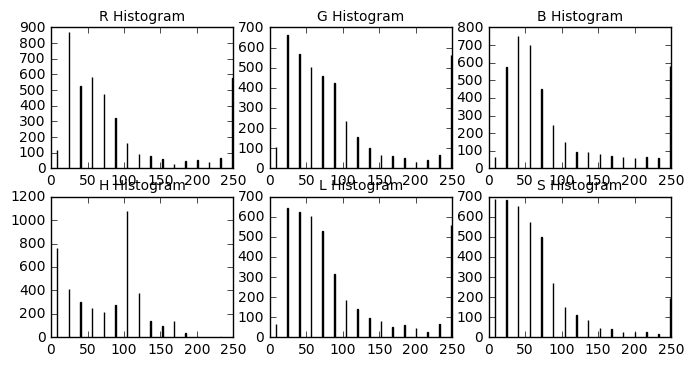

In [11]:
# set tunning parameter
histbin = 16 #number of bins

rh, gh, bh, bincen, hist_rgb = color_hist(image_rgb, nbins=histbin,
                                              bins_range=(0, 256),hist_vec=False)
hh, lh, sh, bincen, hist_hls = color_hist(image_hls, nbins=histbin,
                                              bins_range=(0, 256),hist_vec=False)

print('color hist features size:', hist_rgb.shape)

# Visualize histogram
f, ((ax1, ax2,ax3),(ax4, ax5,ax6) )= plt.subplots(2, 3, figsize=(8,4))

ax1.bar(bincen, rh[0])
ax1.set_title('R Histogram', fontsize=10)

ax2.bar(bincen, gh[0])
ax2.set_title('G Histogram', fontsize=10)


ax3.bar(bincen, bh[0])
ax3.set_title('B Histogram', fontsize=10)

ax4.bar(bincen, hh[0])
ax4.set_title('H Histogram', fontsize=10)

ax5.bar(bincen, lh[0])
ax5.set_title('L Histogram', fontsize=10)

ax6.bar(bincen, sh[0])
ax6.set_title('S Histogram', fontsize=10)


### HOG Feature
Gradient features is also used to capture the signature for a shape. However use the gradient feature directly is sensitive.  Histogram of gradient orientation allows variation  between the shape. The HOG is on the grey scale image.

In [12]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Hog features shape: (4, 4, 2, 2, 8)
Flatterned Hog features size: (512,)


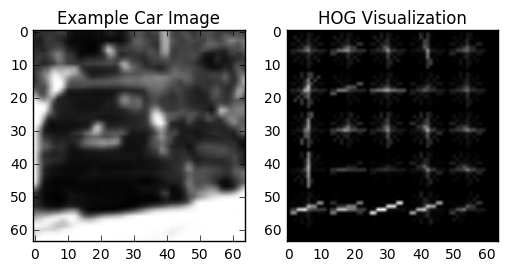

In [13]:
# test if the feature work
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY) # convert to gray scale
# work on grey scale image

# Define HOG parameters
orient = 8
pix_per_cell = 12
cell_per_block = 2

# Call our function with vis=True to see an image output, 
# feature_vec=False to get the feature dimension
hog_features, hog_image = get_hog_features(image_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# flattern the feature to create the feature vector
hog_1d = np.ravel(hog_features) 

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image_gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

# test the funtion
print('Hog features shape:', hog_features.shape)
print('Flatterned Hog features size:', hog_1d.shape)

### Extract Featuress
Combine all the extrected features

In [14]:
def extract_features(image_rgb):
    
    spatial = 8 
    hist_bins = 12 # color hist parameters
    # Define HOG parameters
    orient = 8
    pix_per_cell = 12
    cell_per_block = 2
    
    # apply color conversion if other than 'RGB'  
    image_hls = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HLS)# convert it to HLS
    image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
        
    # Apply bin_spatial() to get spatial color features
    spatial_hls = bin_spatial(image_hls, size=(spatial, spatial))
    spatial_rgb = bin_spatial(image_rgb, size=(spatial, spatial))
        
    # Apply color_hist() also with a color space option now
    hist_hls = color_hist(image_hls, nbins = hist_bins, 
                          bins_range = (0, 256), hist_vec=True)
    hist_rgb = color_hist(image_rgb, nbins= hist_bins, 
                          bins_range = (0, 256), hist_vec=True)       
        
    # Call get_hog_features() with vis=False, feature_vec=True
    hog_grey = get_hog_features(image_gray, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
    # Append the new feature vector to the features list
    features = np.concatenate((spatial_hls,spatial_rgb,
                               hist_hls,hist_rgb,
                               hog_grey))
                                        
    
    return features

### Extract Features from the Training Images

In [15]:
# extract features from the training image
def features_from_data(imgs):
    # Create a list to append feature vectors to
    features_all = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        
        image_rgb = np.uint8(image*255)# convert to 255

        features = extract_features(image_rgb) # extract features
        
        features_all.append(features)
    return features_all                  

In [16]:
# extract feature from car images
car_features_train = features_from_data(cars_train)
notcar_features_train = features_from_data(notcars_train)


car_features_test = features_from_data(cars_test)
notcar_features_test = features_from_data(notcars_test)


X_train = np.vstack((car_features_train, notcar_features_train)).astype(np.float32)   
X_test = np.vstack((car_features_test, notcar_features_test)).astype(np.float32)   

print("Training set:",X_train.shape)
print("Testing set :",X_test.shape)


Training set: (11732, 968)
Testing set : (6726, 968)


### Feature Normalization

In [17]:
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

In [18]:
y_train = np.hstack((np.ones(len(car_features_train)), np.zeros(len(notcar_features_train))))
y_test = np.hstack((np.ones(len(car_features_test)), np.zeros(len(notcar_features_test))))

In [19]:
print('Training set:', scaled_X_train.shape)
print('Test set    :', scaled_X_test.shape)
print('Training set:', y_train.shape)
print('Test set    :', y_test.shape)

Training set: (11732, 968)
Test set    : (6726, 968)
Training set: (11732,)
Test set    : (6726,)


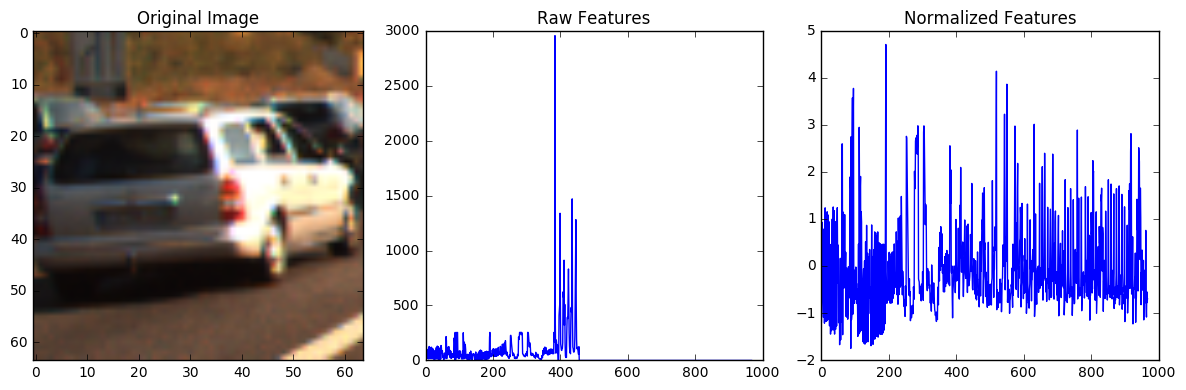

In [20]:
# plot feature normalization
car_ind = np.random.randint(0, len(cars_train))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars_train[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X_train[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X_train[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

### split trainign and test set

In [21]:
X_train, y_train = shuffle( scaled_X_train, y_train, random_state=42)

In [22]:
# Split up data into randomized training and test sets

X_test, X_valid, y_test, y_valid = train_test_split(
    scaled_X_test, y_test, test_size=0.5, random_state=42)

In [23]:
print('Training set:', X_train.shape)
print('Training set:', X_valid.shape)
print('Test set    :', X_test.shape)

Training set: (11732, 968)
Training set: (3363, 968)
Test set    : (3363, 968)


## 2. Define classifier

### Train a classifier

20, min_samples_leaf = 4,max_depth = 6

In [24]:

# max_feature
x = [3] #[3,8,15] #7
# max_depth 
y = [4]#[2,4,10] #8
# tree leaf
z = [4]#[2,4] # 9

for i in x:
    for j in y:
        for k in z:
            print ("ftr: {} ,dpt: {} ,lef: {}".format(i,j,k ))
            clf = RandomForestClassifier(n_estimators = 100,
                                         max_features = i,
                                         max_depth = j,
                                         min_samples_leaf = k,
                                         random_state = 42,) 
            clf.fit(X_train, y_train)
            #predict_labels(clf, X_test, y_test)
            pred = clf.predict_proba(X_valid)[:,1]
            auroc = roc_auc_score(y_valid, pred)
            
            print('auroc = ', round(auroc, 4))

            #print('Validation Accuracy = ', round(clf.score(X_valid, y_valid), 4))


ftr: 3 ,dpt: 4 ,lef: 4
auroc =  0.9677


In [25]:
clf = RandomForestClassifier(n_estimators=100, max_features = 3, min_samples_leaf = 4,max_depth = 4)

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


pred = clf.predict_proba(X_train)[:,1]
auroc = roc_auc_score(y_train, pred)            
print('auroc = ', round(auroc, 4))

pred = clf.predict_proba(X_valid)[:,1]
auroc = roc_auc_score(y_valid, pred)            
print('auroc = ', round(auroc, 4))


pred = clf.predict_proba(X_test)[:,1]
auroc = roc_auc_score(y_test, pred)            
print('auroc = ', round(auroc, 4))

1.12 Seconds to train SVC...
auroc =  0.9996
auroc =  0.9675
auroc =  0.9656


In [26]:
X_all = np.concatenate((X_train,X_valid,X_test))
y_all = np.concatenate((y_train,y_valid,y_test))

clf.fit(X_all, y_all)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=3, max_leaf_nodes=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Test the classifier

## 3.Define Sliding Window

In [27]:
# load test images
img1 = cv2.imread('test_images/test1.jpg')
img2 = cv2.imread('test_images/test2.jpg')
img3 = cv2.imread('test_images/test3.jpg')
img4 = cv2.imread('test_images/test4.jpg')
img5 = cv2.imread('test_images/test5.jpg')
img6 = cv2.imread('test_images/test6.jpg')

### Draw boxes

In [28]:
# draw boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

### sliding window

In [29]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [30]:
# the minimum window size
x_min =[350, 1280]
y_min =[400, 530]
xy_min = (80, 80)

# the maxium window size
x_max =[400, 1280]
y_max =[400, 700]
xy_max = (160, 160)

# intermedian windows
n = 4
x = []
y = []
xy =[]
for i in range(n):
    x_start_stop =[int(x_min[0] + i*(x_max[0]-x_min[0])/(n-1)), 
                   int(x_min[1] + i*(x_max[1]-x_min[1])/(n-1))]
    y_start_stop =[int(y_min[0] + i*(y_max[0]-y_min[0])/(n-1)), 
                   int(y_min[1] + i*(y_max[1]-y_min[1])/(n-1))]
    xy_window    =[int(xy_min[0] + i*(xy_max[0]-xy_min[0])/(n-1)), 
                   int(xy_min[1] + i*(xy_max[1]-xy_min[1])/(n-1))]
    x.append(x_start_stop)
    y.append(y_start_stop)
    xy.append(xy_window)
 

[366, 1280]
[400, 586]
[106, 106]


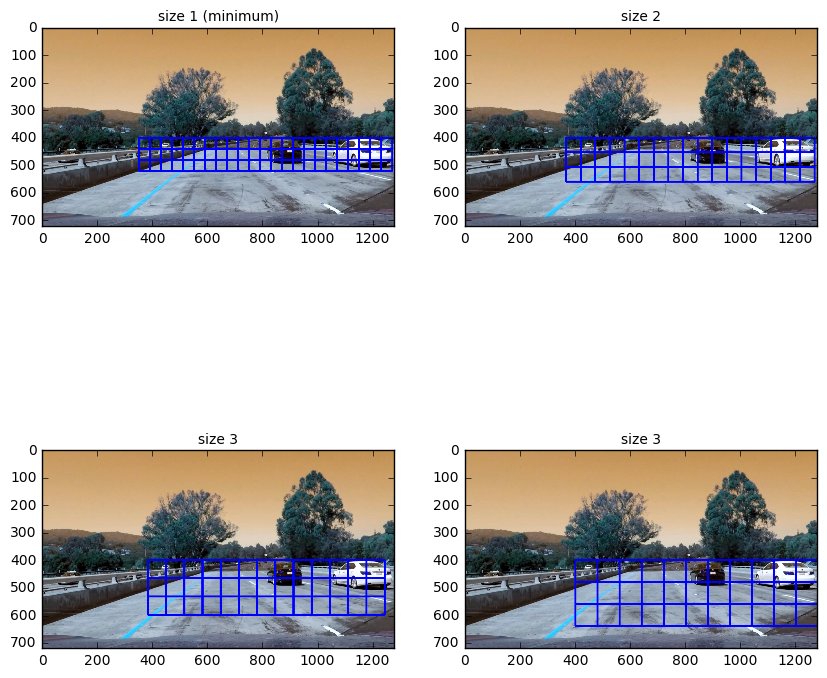

In [31]:
# visualize different window size
x_start_stop = x[1]
y_start_stop = y[1]
xy_window = xy[1]
print(x_start_stop)
print(y_start_stop)
print(xy_window)

windows1 = slide_window(img1, x_start_stop= x[0], y_start_stop = y[0], 
                    xy_window= xy[0], xy_overlap=(0.5, 0.5))
windows2 = slide_window(img1, x_start_stop= x[1], y_start_stop = y[1], 
                    xy_window= xy[1], xy_overlap=(0.5, 0.5))
windows3 = slide_window(img1, x_start_stop= x[2], y_start_stop = y[2], 
                    xy_window= xy[2], xy_overlap=(0.5, 0.5))
windows4 = slide_window(img1, x_start_stop= x[3], y_start_stop = y[3], 
                    xy_window= xy[3], xy_overlap=(0.5, 0.5))

window_img1 = draw_boxes(img1, windows1, color=(0, 0, 255), thick=6)
window_img2 = draw_boxes(img1, windows2, color=(0, 0, 255), thick=6)                    
window_img3 = draw_boxes(img1, windows3, color=(0, 0, 255), thick=6)
window_img4 = draw_boxes(img1, windows4, color=(0, 0, 255), thick=6)


f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,10))
ax1.imshow(window_img1)
ax1.set_title('size 1 (minimum)', fontsize=10)
ax2.imshow(window_img2)
ax2.set_title('size 2', fontsize=10)
ax3.imshow(window_img3)
ax3.set_title('size 3', fontsize=10)
ax4.imshow(window_img4)
ax4.set_title('size 3', fontsize=10)

In [32]:
# combine all windows
windows_all = list(windows1 + windows2 + windows3 + windows4)
print('Number of windows:',len(windows_all))

Number of windows: 120


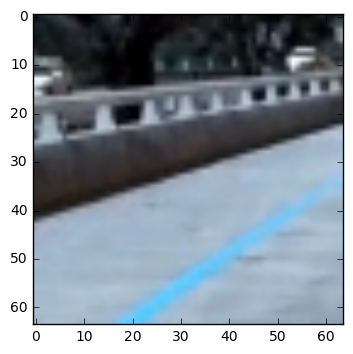

In [33]:
# preprocess the image by crop the window, and resize
def preprocess(img,window):
    # crop the image
    img_crop = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    # resize the image to 64 by 64
    img_resized = cv2.resize(img_crop, (64, 64))
    return img_resized

# test if the function works
img = preprocess(img1,windows3[1])
plt.imshow(img)

In [34]:
def features_from_img(img):
    # Create a list to append feature vectors to
    features_all = []
    
    for n in range(len(windows_all)):
        # Read in each one by one
        image_rgb = preprocess(img,windows_all[n])
        
        features = extract_features(image_rgb) # extract features
        
        features_all.append(features)
        
    # scale
    scaled_features = X_scaler.transform(features_all)
    # Return list of feature vectors
    return scaled_features

In [35]:
# get 
img_features = features_from_img(img1)

# prediction
pred = clf.predict_proba(img_features)[:,1]
print(pred[0:10])

[ 0.3778081   0.48650355  0.55076794  0.49110947  0.51465877  0.40332195
  0.30405842  0.30452188  0.32418666  0.33452589]


In [57]:
# get windows with car images
def get_car_windows(pred):
    windows_car = []
    for n in range(len(pred)):
        if pred[n] > 0.50:
            windows_car.append(windows_all[n])
    return windows_car

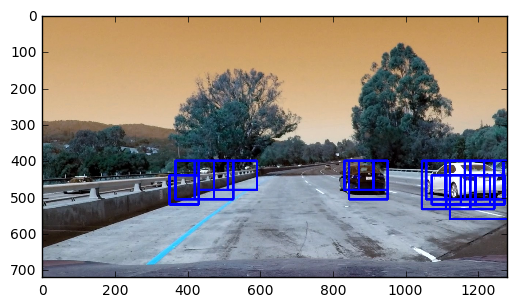

In [58]:
windows_car = get_car_windows(pred)

# plot the windows put on the images
img_box = draw_boxes(img1, windows_car, color=(0, 0, 255), thick=6)
plt.imshow(img_box)

### create bounding box

In [38]:
def find_cars(img):
    # extract feature
    img_features = features_from_img(img)
    
    # prediction
    pred = clf.predict_proba(img_features)[:,1]
    
    # get windows with car images
    windows_car = get_car_windows(pred)
    
    return windows_car

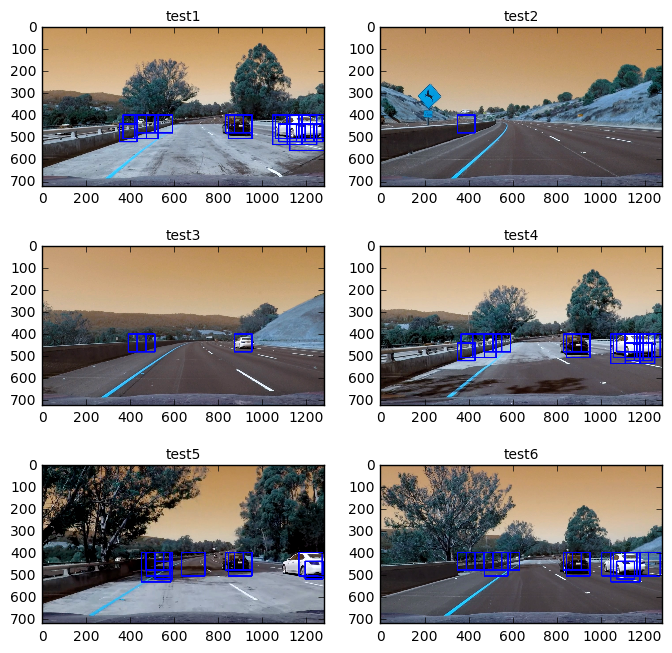

In [59]:
# all test images
windows_car = find_cars(img1)
img_box1 = draw_boxes(img1, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img2)
img_box2 = draw_boxes(img2, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img3)
img_box3 = draw_boxes(img3, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img4)
img_box4 = draw_boxes(img4, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img5)
img_box5 = draw_boxes(img5, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img6)
img_box6 = draw_boxes(img6, windows_car, color=(0, 0, 255), thick=6)

f, ((ax1, ax2),(ax3, ax4),(ax5, ax6))= plt.subplots(3, 2, figsize=(8,8))
ax1.imshow(img_box1)
ax1.set_title('test1', fontsize=10)
ax2.imshow(img_box2)
ax2.set_title('test2', fontsize=10)
ax3.imshow(img_box3)
ax3.set_title('test3', fontsize=10)
ax4.imshow(img_box4)
ax4.set_title('test4', fontsize=10)
ax5.imshow(img_box5)
ax5.set_title('test5', fontsize=10)
ax6.imshow(img_box6)
ax6.set_title('test6', fontsize=10)

### Heatmap

In [40]:
# create a heat map
def add_heat(heatmap, boxlist):
    # Iterate through list of bboxes
    
    #heatmap = heatmap*0.5 # cool the map
    
    for box in boxlist:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

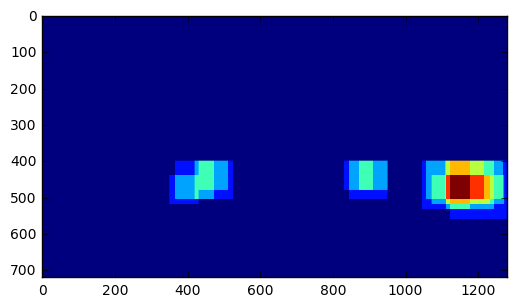

In [41]:
image = img1
bboxes = find_cars(image)

# inicalize heat map
heat = np.zeros_like(image[:,:,0]).astype(np.float)

heatmap = add_heat(heat, bboxes)
plt.imshow(heatmap)


In [42]:
def apply_upper_threshold(heatmap, upper):
    # Zero out pixels below the threshold
    heatmap[heatmap > upper] = 1
    # Return thresholded map
    return heatmap

In [43]:
def apply_lower_threshold(heatmap, lower):
    # Zero out pixels below the threshold
    heatmap[heatmap < lower] = 0
    # Return thresholded map
    return heatmap

3 cars found


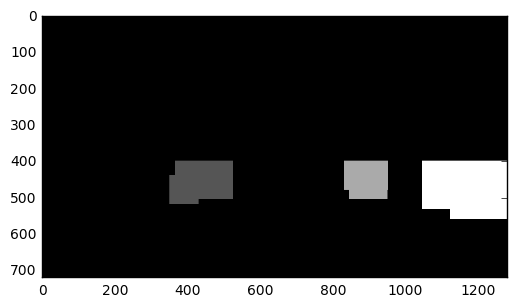

In [44]:
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

In [45]:
def find_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    draw_img = np.copy(img)
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        #cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
        bboxes.append(bbox)
    # Return the boxes
    #bboxes.append(bbox)
    return bboxes

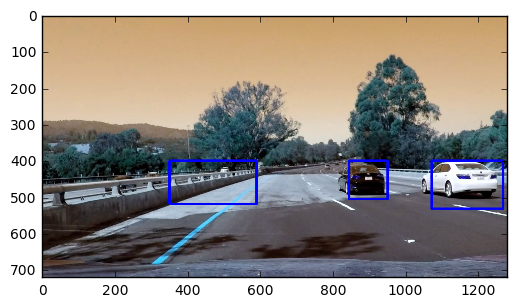

In [46]:
image = img4
boxes = find_cars(image)

heat = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heat, boxes)
heatmap = apply_lower_threshold(heatmap, 1)
labels = label(heatmap)

bboxes = find_labeled_bboxes(image, labels)

img_box = draw_boxes(image, bboxes, color=(0, 0, 255), thick=6)

plt.imshow(img_box)

### Tracking Functions

In [47]:
def track_car(cntrd,old_Cars):
    threshod_dist = 40
    Dist = []
    if not old_Cars: # if it's empty
        car_found = False
        car_id = 0
        return car_found,car_id
    else:
        for car in old_Cars:
            dist = cal_dist(cntrd, car.average_centroid)
            Dist.append(dist)

        car_id = np.argmin(Dist)
        if Dist[car_id] < threshod_dist:
            car_found = True
        else:
            car_found = False
        return car_found, car_id

### calculate centroid distance

In [48]:
# caculate distance
def cal_dist(centroid1, centroid2):
    x1 = centroid1[0]
    y1 = centroid1[1]
    x2 = centroid2[0]
    y2 = centroid2[1]
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

# test the function
centroid1 = (1,2)
centroid2 = (2,5)
dist = cal_dist(centroid1, centroid2)
print('Distance:', dist)

Distance: 3.16227766017


In [49]:
# find centroy and size of bounding box
def find_box_centroid_size(bboxes):
    box_centroids = []
    box_size = []
    
    for box in bboxes:
        x = int((box[0][0] + box[1][0])/2)
        y = int((box[0][1] + box[1][1])/2)
        box_centroids.append((x,y))

        width =  int((box[1][0] - box[0][0])/2)
        height = int((box[1][1] - box[0][1])/2)
        box_size.append((width,height))
    return box_centroids, box_size

In [50]:
# draw filtered boxes
def find_car_box(Old_Cars, detected_threshold = 0.51):
    box2 = []
    for car2 in Old_Cars:
        if car2.detected > detected_threshold:
            offset = car2.average_centroid          
            width = car2.width
            height = car2.height
            bbox0 = (int(-width+offset[0]),
                     int(-height+offset[1]))
            bbox1 = (int(width+offset[0]),
                     int(height+offset[1]))
            box2.append((bbox0,bbox1))
    return box2

## Video pipline

In [60]:
# video pipline

def process_img(image):
    class car():
        def __init__(self):
            self.average_centroid= (0,0) # average centroid
            self.width = 0 # average box width
            self.height = 0 # average height
            self.detected = 0.5  # moving average
    
    global Detected_Cars
    global heatmap
    
    # Here are the bounding boxes I used
    draw_img = np.copy(image)
    
    # the inicail box
    boxes = find_cars(image)
    # draw the inical boxed
    draw_img = draw_boxes(draw_img, boxes, color=(0, 0, 255), thick=2)

    
    # create heat map
    heatmap_new = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap_new = add_heat(heatmap_new, boxes) # add heat map 
    heatmap_new = apply_upper_threshold(heatmap_new,1)

    heatmap = 0.9*heatmap + 0.1*heatmap_new
        
    
    # wrap heatmap (make a funciton)
    wrap_img = np.zeros_like(image)
    wrap_img[:,:,1] = heatmap[:]*250
    draw_img = cv2.addWeighted(draw_img, 1, wrap_img, 0.5, 0)

    heatmap_sure = np.copy(heatmap)
    heatmap_sure = apply_lower_threshold(heatmap_sure, 0.97)
    labels = label(heatmap_sure) #labels
    bounding_boxes = find_labeled_bboxes(image, labels)
    
     
    # find centroy and size of bounding box
    centroids,box_size = find_box_centroid_size(bounding_boxes)
    


    New_Cars = []
    for n in range(len(centroids)):
        # find the nearest car            
        car_found, k = track_car(centroids[n],Detected_Cars) # return a number 

        if car_found  == True:
            # update old car
            Detected_Cars[k].average_centroid = (int(0.9*Detected_Cars[k].average_centroid[0] + 0.1*centroids[n][0]),
                                    int(0.9*Detected_Cars[k].average_centroid[1] + 0.1*centroids[n][1]))         
            Detected_Cars[k].width =   math.ceil(0.9*Detected_Cars[k].width + 0.1*box_size[n][0]) # round up
            Detected_Cars[k].height =  math.ceil(0.9*Detected_Cars[k].height + 0.1*box_size[n][1])
            Detected_Cars[k].detected = Detected_Cars[k].detected + 0.2

        else: # add new car
            new_car = car()
            new_car.average_centroid = centroids[n]
            new_car.width =  box_size[n][0]
            new_car.height = box_size[n][1]            
            New_Cars.append(new_car)
            
    # combine new_cars to old cars
    Detected_Cars2 = list(Detected_Cars) # make a copy
    Detected_Cars = New_Cars[:] # add new cars
    if Detected_Cars2: # if is not empty
        for car in Detected_Cars2:
            if car.detected > 0.17: 
                Detected_Cars.append(car) # add old cars
            
    # find car that is consistent
    car_boxes = find_car_box(Detected_Cars, detected_threshold = 0.55) #0.51
    draw_img = draw_boxes(draw_img, car_boxes, color=(255, 0, 0), thick=5)         
            
    # depreciate old car value
    for car in Detected_Cars:
        car.detected = car.detected*0.8 # fade old value
    
    return draw_img

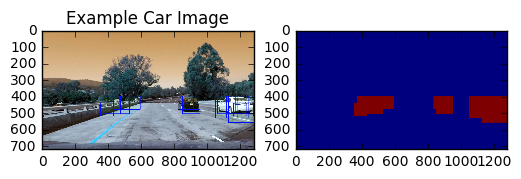

In [61]:
global Detected_Cars
global heatmap
heatmap = np.zeros_like(img1[:,:,0]).astype(np.float)
Detected_Cars = []
img1_x =process_img(img1)
plt.subplot(121)
plt.imshow(img1_x)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(heatmap)


In [62]:
#process on a video
global Detected_Cars
global heatmap

heatmap = np.zeros_like(img1[:,:,0]).astype(np.float) # incialize 
Detected_Cars = []
white_output = 'project_video_after.mp4'
clip1 = VideoFileClip("/Users/daruizhang/Documents/CarND_P4_Video/project_video.mp4")
#clip1 = VideoFileClip("/Users/daruizhang/Documents/CarND_P4_Video/challenge_video.mp4")
#clip1 = VideoFileClip("/Users/daruizhang/Documents/CarND_P4_Video/harder_challenge_video.mp4")

white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_after.mp4
[MoviePy] Writing video project_video_after.mp4


100%|█████████▉| 1260/1261 [05:23<00:00,  4.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_after.mp4 

CPU times: user 4min 58s, sys: 18.5 s, total: 5min 17s
Wall time: 5min 24s


In [63]:
# show video stream
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))